In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from stellargraph import StellarGraph
from stellargraph.data import TemporalRandomWalk
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
%matplotlib inline

2024-04-29 19:10:55.856058: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Loading the Datasets - Bike Data and Station Data

In [2]:
data_q1 = pd.read_csv("indego2023q1.csv")
data_q2 = pd.read_csv("indego2023q2.csv")
data_q3 = pd.read_csv("indego2023q3.csv")
data_q4 = pd.read_csv("indego2023q4.csv")
station_data = pd.read_csv('indegostations2024new.csv')

/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_8240/1747634213.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data_q2 = pd.read_csv("indego2023q2.csv")
/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_8240/1747634213.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data_q3 = pd.read_csv("indego2023q3.csv")
/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_8240/1747634213.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data_q4 = pd.read_csv("indego2023q4.csv")


In [3]:
print(data_q1.shape)
print(data_q2.shape)
print(data_q3.shape)
print(data_q4.shape)
print(station_data.shape)

(166858, 15)
(291894, 15)
(353256, 15)
(272539, 15)
(277, 4)


#### Combining each and every quarter data into one dataset

In [4]:
data = pd.concat([data_q1, data_q2, data_q3, data_q4], ignore_index=True)

In [5]:
data.shape

(1084547, 15)

In [6]:
data.head(10)

trip_id  duration     start_time       end_time  start_station  \
0  579507686        70  1/1/2023 0:00  1/1/2023 1:10           3063   
1  579499091        17  1/1/2023 0:05  1/1/2023 0:22           3190   
2  579499089        11  1/1/2023 0:06  1/1/2023 0:17           3182   
3  579499087         1  1/1/2023 0:08  1/1/2023 0:09           3026   
4  579499085        27  1/1/2023 0:09  1/1/2023 0:36           3046   
5  579499083        13  1/1/2023 0:10  1/1/2023 0:23           3026   
6  579499081         5  1/1/2023 0:13  1/1/2023 0:18           3046   
7  579499079        27  1/1/2023 0:16  1/1/2023 0:43           3070   
8  579834968        20  1/1/2023 0:20  1/1/2023 0:40           3164   
9  579499077        22  1/1/2023 0:23  1/1/2023 0:45           3154   

   start_lat  start_lon  end_station    end_lat    end_lon bike_id  \
0  39.946331 -75.169800         3063  39.946331 -75.169800   22584   
1  39.948921 -75.169907         3207  39.954411 -75.192001    5281   
2  39.950809 -75.169533         3102  39.967590 -75.179520   22366   
3  39.941818 -75.145500         3026  39.941818 -75.145500   17780   
4  39.950119 -75.144722         3112  39.953732 -75.218246   16897   
5  39.941818 -75.145500         3041  39.968491 -75.135460   21897   
6  39.950119 -75.144722         3295  39.950279 -75.160271   19836   
7  39.960621 -75.139832         3205  39.954048 -75.167831   22769   
8  39.928139 -75.165154         3000        NaN        NaN   16557   
9  39.959240 -75.158211         3028  39.940609 -75.149582    5257   

   plan_duration trip_route_category passholder_type bike_type  
0            365          Round Trip       Indego365  electric  
1             30             One Way        Indego30  standard  
2             30             One Way        Indego30  electric  
3             30          Round Trip        Indego30  electric  
4             30             One Way        Indego30  electric  
5             30             One Way        Indego30  electric  
6             30             One Way        Indego30  electric  
7              1             One Way        Day Pass  electric  
8             30             One Way        Indego30  electric  
9            365             One Way       Indego365  standard

In [7]:
station_data.head()

Station_ID                       Station_Name Day of Go_live_date    Status
0        3000                    Virtual Station           4/23/2015    Active
1        3004  Municipal Services Building Plaza           4/23/2015  Inactive
2        3005                  Welcome Park, NPS           4/23/2015    Active
3        3006                      40th & Spruce           4/23/2015    Active
4        3007             11th & Pine, Kahn Park           4/23/2015    Active

#### Data Pre-processing
##### Finding Missing values in each dataset and removing them

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084547 entries, 0 to 1084546
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   trip_id              1084547 non-null  int64  
 1   duration             1084547 non-null  int64  
 2   start_time           1084547 non-null  object 
 3   end_time             1084547 non-null  object 
 4   start_station        1084547 non-null  int64  
 5   start_lat            1084516 non-null  float64
 6   start_lon            1084516 non-null  float64
 7   end_station          1084547 non-null  int64  
 8   end_lat              1072393 non-null  float64
 9   end_lon              1072393 non-null  float64
 10  bike_id              1084547 non-null  object 
 11  plan_duration        1084547 non-null  int64  
 12  trip_route_category  1084547 non-null  object 
 13  passholder_type      1084168 non-null  object 
 14  bike_type            1084547 non-null  object 
dty

In [9]:
data.isnull().sum()

trip_id                    0
duration                   0
start_time                 0
end_time                   0
start_station              0
start_lat                 31
start_lon                 31
end_station                0
end_lat                12154
end_lon                12154
bike_id                    0
plan_duration              0
trip_route_category        0
passholder_type          379
bike_type                  0
dtype: int64

In [10]:
station_data.isnull().sum()

Station_ID             0
Station_Name           0
Day of Go_live_date    0
Status                 0
dtype: int64

In [11]:
station_data[station_data["Status"]=="Active"].count()

Station_ID             242
Station_Name           242
Day of Go_live_date    242
Status                 242
dtype: int64

In [12]:
data = data.dropna()

In [13]:
data.isnull().sum()

trip_id                0
duration               0
start_time             0
end_time               0
start_station          0
start_lat              0
start_lon              0
end_station            0
end_lat                0
end_lon                0
bike_id                0
plan_duration          0
trip_route_category    0
passholder_type        0
bike_type              0
dtype: int64

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1072029 entries, 0 to 1084546
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   trip_id              1072029 non-null  int64  
 1   duration             1072029 non-null  int64  
 2   start_time           1072029 non-null  object 
 3   end_time             1072029 non-null  object 
 4   start_station        1072029 non-null  int64  
 5   start_lat            1072029 non-null  float64
 6   start_lon            1072029 non-null  float64
 7   end_station          1072029 non-null  int64  
 8   end_lat              1072029 non-null  float64
 9   end_lon              1072029 non-null  float64
 10  bike_id              1072029 non-null  object 
 11  plan_duration        1072029 non-null  int64  
 12  trip_route_category  1072029 non-null  object 
 13  passholder_type      1072029 non-null  object 
 14  bike_type            1072029 non-null  object 
dtypes: 

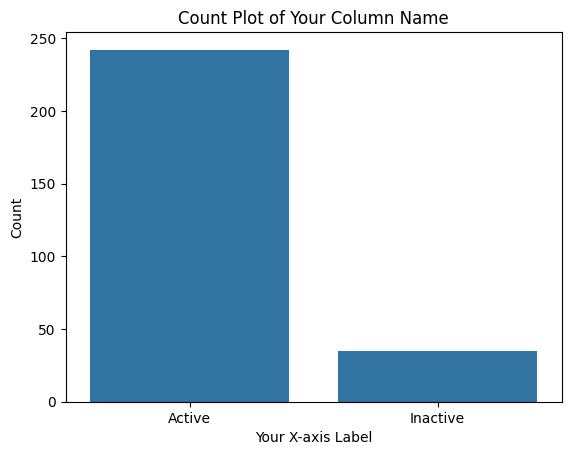

In [15]:
sns.countplot(x='Status', data=station_data)

# Add labels and title if desired
plt.xlabel('Your X-axis Label')
plt.ylabel('Count')
plt.title('Count Plot of Your Column Name')

plt.show()

In [16]:
station_data[['Month', 'Date', 'Year']] = station_data['Day of Go_live_date'].str.split('/', expand=True)

# Deleting the original date_column
station_data.drop('Day of Go_live_date', axis=1, inplace=True)

# Display the modified DataFrame
station_data.head

<bound method NDFrame.head of      Station_ID                       Station_Name    Status Month Date  Year
0          3000                    Virtual Station    Active     4   23  2015
1          3004  Municipal Services Building Plaza  Inactive     4   23  2015
2          3005                  Welcome Park, NPS    Active     4   23  2015
3          3006                      40th & Spruce    Active     4   23  2015
4          3007             11th & Pine, Kahn Park    Active     4   23  2015
..          ...                                ...       ...   ...  ...   ...
272        3361      18th & Fernon, Aquinas Center    Active    12    5  2023
273        3364                     12th & Filbert    Active    11   20  2023
274        3365         32nd & Baring, Drexel Park    Active    11   28  2023
275        3366                 57th & Westminster    Active    12    8  2023
276        3368                      23rd & Master    Active    12   20  2023

[277 rows x 6 columns]>

In [17]:
station_data.head()

Station_ID                       Station_Name    Status Month Date  Year
0        3000                    Virtual Station    Active     4   23  2015
1        3004  Municipal Services Building Plaza  Inactive     4   23  2015
2        3005                  Welcome Park, NPS    Active     4   23  2015
3        3006                      40th & Spruce    Active     4   23  2015
4        3007             11th & Pine, Kahn Park    Active     4   23  2015

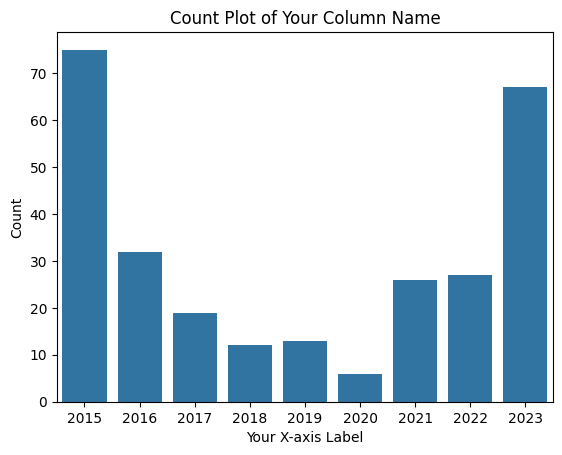

In [18]:
sns.countplot(x='Year', data=station_data)

# Add labels and title if desired
plt.xlabel('Your X-axis Label')
plt.ylabel('Count')
plt.title('Count Plot of Your Column Name')

plt.show()

In [19]:
station_data.isnull().sum()

Station_ID      0
Station_Name    0
Status          0
Month           0
Date            0
Year            0
dtype: int64

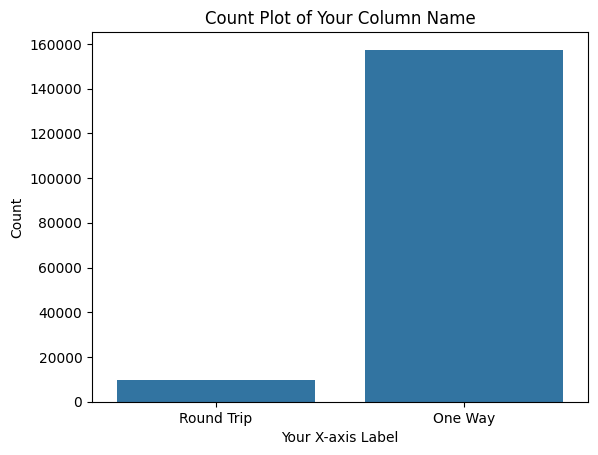

In [20]:
# Create a count plot for the specified column
sns.countplot(x='trip_route_category', data=data_q1)

# Add labels and title if desired
plt.xlabel('Your X-axis Label')
plt.ylabel('Count')
plt.title('Count Plot of Your Column Name')

plt.show()

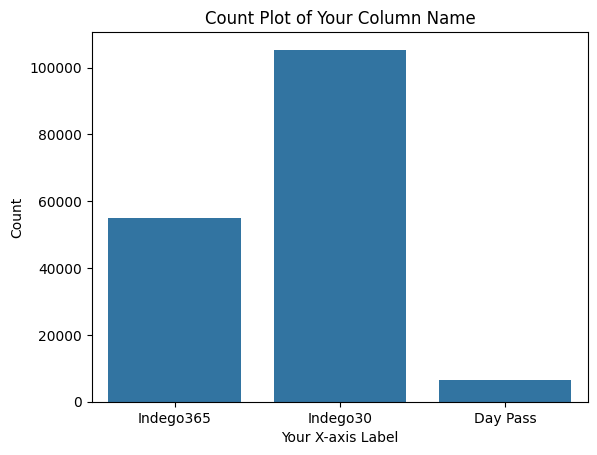

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
# df = pd.read_csv('your_file.csv')  # Uncomment and modify if needed

# Create a count plot for the specified column
sns.countplot(x='passholder_type', data=data_q1)

# Add labels and title if desired
plt.xlabel('Your X-axis Label')
plt.ylabel('Count')
plt.title('Count Plot of Your Column Name')

plt.show()

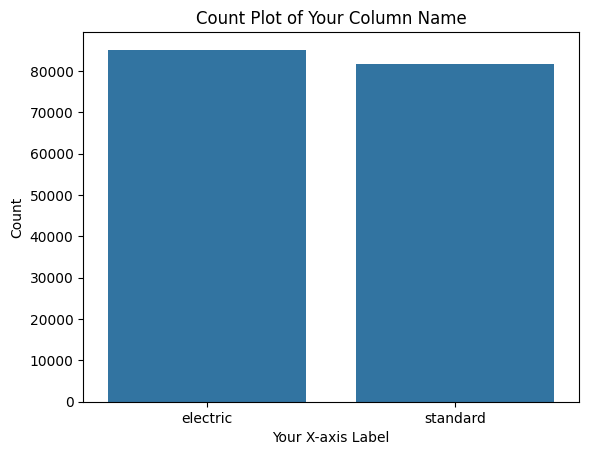

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
# df = pd.read_csv('your_file.csv')  # Uncomment and modify if needed

# Create a count plot for the specified column
sns.countplot(x='bike_type', data=data_q1)

# Add labels and title if desired
plt.xlabel('Your X-axis Label')
plt.ylabel('Count')
plt.title('Count Plot of Your Column Name')

plt.show()

In [23]:
# import plotly.express as px

# # Sample DataFrame
# # Replace this with your actual DataFrame
# # df = pd.DataFrame({
# #     'lat': [39.9526, 39.9800],  # Example latitudes
# #     'lon': [-75.1652, -75.1500]  # Example longitudes
# # })

# # Create a scatter plot on a map
# fig = px.scatter_geo(data,
#                      lat='start_lat',
#                      lon='start_lon',
#                      projection="natural earth",  # or 'mercator' for a different style
#                      title='Locations in Philadelphia')

# # Zoom the map to your data points' location
# fig.update_geos(fitbounds="locations")

# # Show the plot
# fig.show()

#### Merging the Trip data and Station data and then rearranging the columns. Result is the final_data

In [24]:
final_data = pd.merge(data, station_data[['Station_ID', 'Station_Name']], how='left', left_on='start_station', right_on='Station_ID')
final_data.drop('Station_ID', axis=1, inplace=True)

In [25]:
final_data.head(10)

trip_id  duration     start_time       end_time  start_station  \
0  579507686        70  1/1/2023 0:00  1/1/2023 1:10           3063   
1  579499091        17  1/1/2023 0:05  1/1/2023 0:22           3190   
2  579499089        11  1/1/2023 0:06  1/1/2023 0:17           3182   
3  579499087         1  1/1/2023 0:08  1/1/2023 0:09           3026   
4  579499085        27  1/1/2023 0:09  1/1/2023 0:36           3046   
5  579499083        13  1/1/2023 0:10  1/1/2023 0:23           3026   
6  579499081         5  1/1/2023 0:13  1/1/2023 0:18           3046   
7  579499079        27  1/1/2023 0:16  1/1/2023 0:43           3070   
8  579499077        22  1/1/2023 0:23  1/1/2023 0:45           3154   
9  579499075         9  1/1/2023 0:23  1/1/2023 0:32           3182   

   start_lat  start_lon  end_station    end_lat    end_lon bike_id  \
0  39.946331 -75.169800         3063  39.946331 -75.169800   22584   
1  39.948921 -75.169907         3207  39.954411 -75.192001    5281   
2  39.950809 -75.169533         3102  39.967590 -75.179520   22366   
3  39.941818 -75.145500         3026  39.941818 -75.145500   17780   
4  39.950119 -75.144722         3112  39.953732 -75.218246   16897   
5  39.941818 -75.145500         3041  39.968491 -75.135460   21897   
6  39.950119 -75.144722         3295  39.950279 -75.160271   19836   
7  39.960621 -75.139832         3205  39.954048 -75.167831   22769   
8  39.959240 -75.158211         3028  39.940609 -75.149582    5257   
9  39.950809 -75.169533         3064  39.938400 -75.173271   22420   

   plan_duration trip_route_category passholder_type bike_type  \
0            365          Round Trip       Indego365  electric   
1             30             One Way        Indego30  standard   
2             30             One Way        Indego30  electric   
3             30          Round Trip        Indego30  electric   
4             30             One Way        Indego30  electric   
5             30             One Way        Indego30  electric   
6             30             One Way        Indego30  electric   
7              1             One Way        Day Pass  electric   
8            365             One Way       Indego365  standard   
9            365             One Way       Indego365  electric   

                 Station_Name  
0                 17th & Pine  
1               17th & Locust  
2               17th & Sansom  
3               2nd & Lombard  
4                2nd & Market  
5               2nd & Lombard  
6                2nd & Market  
7  Spring Garden Station, MFL  
8           12th & Callowhill  
9               17th & Sansom

In [26]:
final_data.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type', 'Station_Name'],
      dtype='object')

In [27]:
columns = ['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type', 'Start_Station_Name']

In [28]:
final_data.columns = columns

In [29]:
final_data.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type', 'Start_Station_Name'],
      dtype='object')

In [30]:
final_data = pd.merge(final_data, station_data[['Station_ID', 'Station_Name']], how='left', left_on='end_station', right_on='Station_ID')
final_data.drop('Station_ID', axis=1, inplace=True)

In [31]:
final_data.head()

trip_id  duration     start_time       end_time  start_station  \
0  579507686        70  1/1/2023 0:00  1/1/2023 1:10           3063   
1  579499091        17  1/1/2023 0:05  1/1/2023 0:22           3190   
2  579499089        11  1/1/2023 0:06  1/1/2023 0:17           3182   
3  579499087         1  1/1/2023 0:08  1/1/2023 0:09           3026   
4  579499085        27  1/1/2023 0:09  1/1/2023 0:36           3046   

   start_lat  start_lon  end_station    end_lat    end_lon bike_id  \
0  39.946331 -75.169800         3063  39.946331 -75.169800   22584   
1  39.948921 -75.169907         3207  39.954411 -75.192001    5281   
2  39.950809 -75.169533         3102  39.967590 -75.179520   22366   
3  39.941818 -75.145500         3026  39.941818 -75.145500   17780   
4  39.950119 -75.144722         3112  39.953732 -75.218246   16897   

   plan_duration trip_route_category passholder_type bike_type  \
0            365          Round Trip       Indego365  electric   
1             30             One Way        Indego30  standard   
2             30             One Way        Indego30  electric   
3             30          Round Trip        Indego30  electric   
4             30             One Way        Indego30  electric   

  Start_Station_Name                                Station_Name  
0        17th & Pine                                 17th & Pine  
1      17th & Locust                             34th & Chestnut  
2      17th & Sansom  Pennsylvania & Fairmount Perelman Building  
3      2nd & Lombard                               2nd & Lombard  
4       2nd & Market                               48th & Spruce

In [32]:
final_data.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type', 'Start_Station_Name', 'Station_Name'],
      dtype='object')

In [33]:
columns = ['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type', 'Start_Station_Name', 'End_Station_Name']

In [34]:
final_data.columns = columns

In [35]:
final_data = final_data[['trip_id', 'duration', 'start_time', 'end_time', 'start_station','Start_Station_Name',
       'start_lat', 'start_lon', 'end_station','End_Station_Name','end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type' ]]

In [36]:
final_data.head()

trip_id  duration     start_time       end_time  start_station  \
0  579507686        70  1/1/2023 0:00  1/1/2023 1:10           3063   
1  579499091        17  1/1/2023 0:05  1/1/2023 0:22           3190   
2  579499089        11  1/1/2023 0:06  1/1/2023 0:17           3182   
3  579499087         1  1/1/2023 0:08  1/1/2023 0:09           3026   
4  579499085        27  1/1/2023 0:09  1/1/2023 0:36           3046   

  Start_Station_Name  start_lat  start_lon  end_station  \
0        17th & Pine  39.946331 -75.169800         3063   
1      17th & Locust  39.948921 -75.169907         3207   
2      17th & Sansom  39.950809 -75.169533         3102   
3      2nd & Lombard  39.941818 -75.145500         3026   
4       2nd & Market  39.950119 -75.144722         3112   

                             End_Station_Name    end_lat    end_lon bike_id  \
0                                 17th & Pine  39.946331 -75.169800   22584   
1                             34th & Chestnut  39.954411 -75.192001    5281   
2  Pennsylvania & Fairmount Perelman Building  39.967590 -75.179520   22366   
3                               2nd & Lombard  39.941818 -75.145500   17780   
4                               48th & Spruce  39.953732 -75.218246   16897   

   plan_duration trip_route_category passholder_type bike_type  
0            365          Round Trip       Indego365  electric  
1             30             One Way        Indego30  standard  
2             30             One Way        Indego30  electric  
3             30          Round Trip        Indego30  electric  
4             30             One Way        Indego30  electric

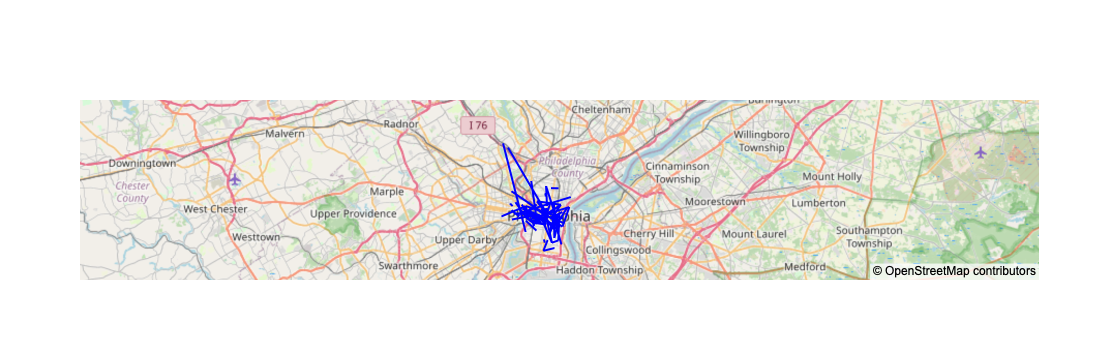

In [37]:
# Randomly sample 100 rows from the dataframe
sampled_df = final_data.sample(n=100)

# Your Mapbox access token
mapbox_access_token = 'YOUR_MAPBOX_ACCESS_TOKEN'

fig = go.Figure()

for i, row in sampled_df.iterrows():
    fig.add_trace(
        go.Scattermapbox(
            mode = "lines",
            lon = [row['start_lon'], row['end_lon']],
            lat = [row['start_lat'], row['end_lat']],
            marker = {'size': 10},
            line = dict(width = 2, color = 'blue'),
        )
    )

fig.update_layout(

    mapbox = {
        'accesstoken': mapbox_access_token,
        'style': "open-street-map", # or "dark", "satellite", etc.
        'zoom': 10, # Adjust zoom
        'center': {'lat': 39.9526, 'lon': -75.1652}, # Center on Philadelphia
    },
    showlegend = False,
)

fig.show()

In [38]:
start_stations = final_data[['Start_Station_Name', 'start_lat', 'start_lon']]
end_stations = final_data[['End_Station_Name', 'end_lat', 'end_lon']]

# Rename columns to unify them
start_stations.columns = ['Station Name', 'Latitude', 'Longitude']
end_stations.columns = ['Station Name', 'Latitude', 'Longitude']

# Concatenate both DataFrames
all_stations = pd.concat([start_stations, end_stations], ignore_index=True)

# Remove duplicates
unique_stations = all_stations.drop_duplicates(subset=['Latitude', 'Longitude'])

unique_stations.head()

Station Name   Latitude  Longitude
0    17th & Pine  39.946331 -75.169800
1  17th & Locust  39.948921 -75.169907
2  17th & Sansom  39.950809 -75.169533
3  2nd & Lombard  39.941818 -75.145500
4   2nd & Market  39.950119 -75.144722

In [39]:
unique_stations.shape

(251, 3)

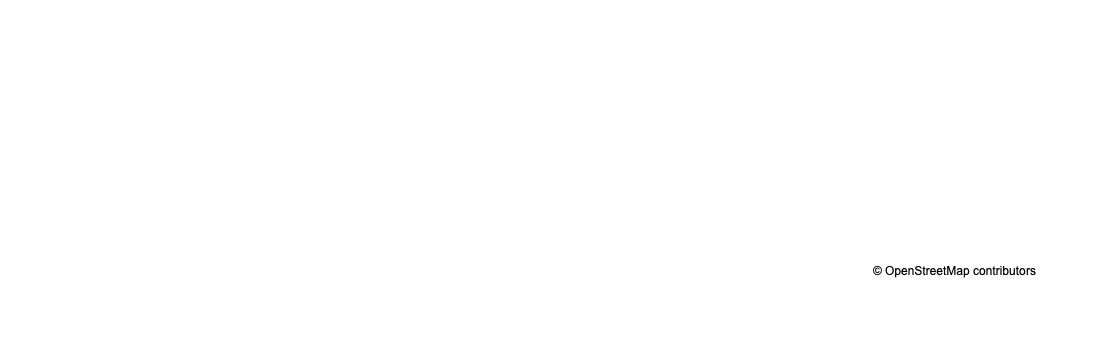

In [40]:
fig = px.scatter_mapbox(unique_stations,
                        lat="Latitude",
                        lon="Longitude",
                        hover_name="Station Name",
                        zoom=13,
                        mapbox_style="open-street-map")

fig.show()

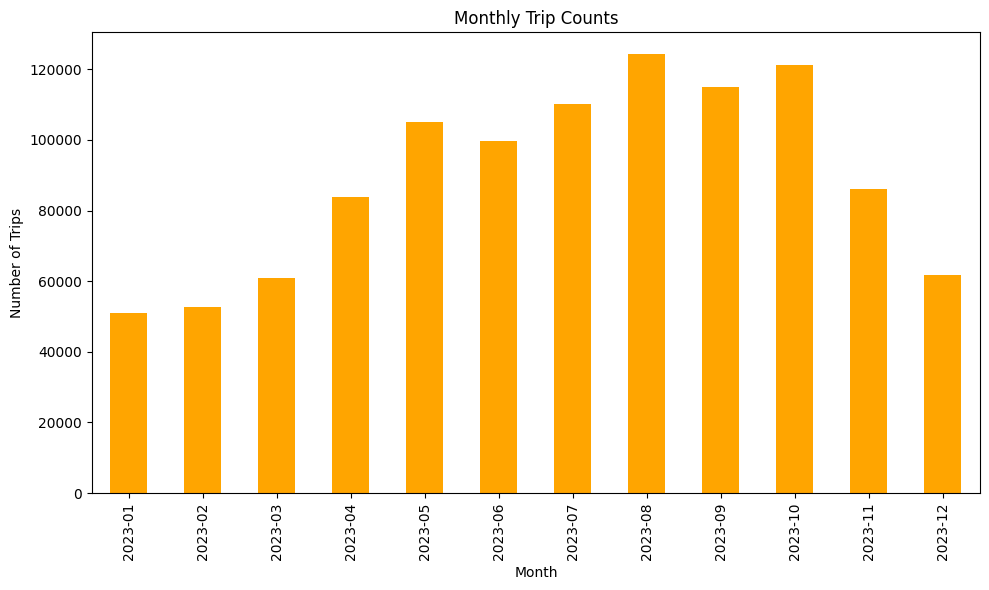

In [41]:
final_data['Start Date'] = pd.to_datetime(final_data['start_time'])

# Extract the month from the Start Date
final_data['Month'] = final_data['Start Date'].dt.to_period('M')

# Count the number of trips per month
monthly_trip_counts = final_data['Month'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
monthly_trip_counts.plot(kind='bar', color='orange')
plt.title('Monthly Trip Counts')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

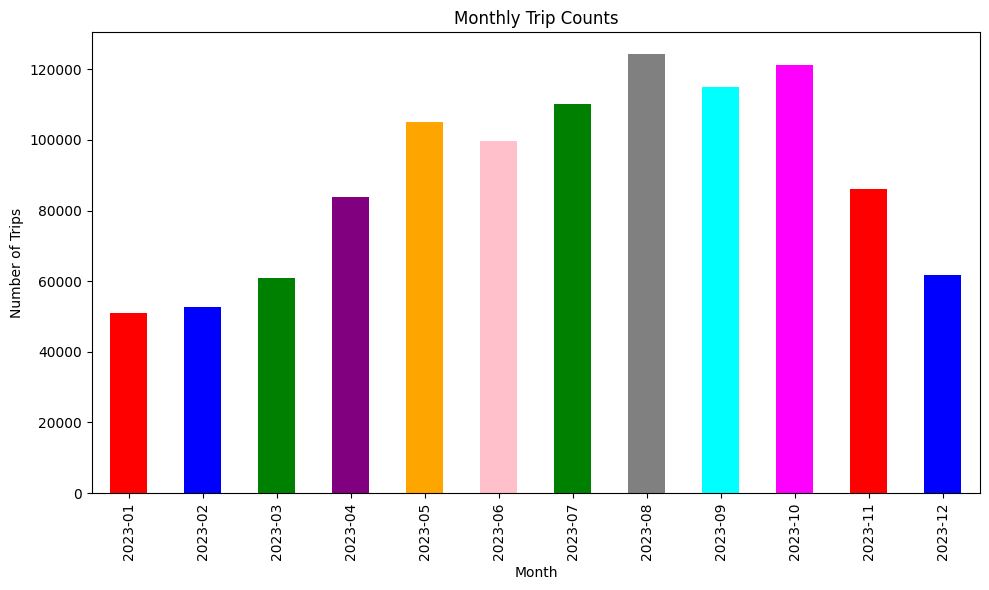

In [42]:
# Define a list of colors
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'green', 'gray', 'cyan', 'magenta']

# Make sure the list is as long as the number of bars you have
# If you have more bars than colors, you can cycle the colors with itertools.cycle
import itertools
color_cycle = itertools.cycle(colors)
colored_bars = list(itertools.islice(color_cycle, len(monthly_trip_counts)))

# Plot
plt.figure(figsize=(10, 6))
monthly_trip_counts.plot(kind='bar', color=colored_bars)
plt.title('Monthly Trip Counts')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#### Applying the model

In [43]:
embedding_size = 128

def positive_and_negative_links(g, edges):
    pos = list(edges[["source", "target"]].itertuples(index=False))
    neg,pos = sample_negative_examples(g, pos)
    return pos, neg


def sample_negative_examples(g, positive_examples):
    positive_set = set(positive_examples)
    def valid_neg_edge(src, tgt):
        return (
            # no self-loops
            src != tgt
            and
            # neither direction of the edge should be a positive one
            (src, tgt) not in positive_set
            and (tgt, src) not in positive_set
        )

    possible_neg_edges = [
        (src, tgt) for src in g.nodes() for tgt in g.nodes() if valid_neg_edge(src, tgt)
    ]
    return random.sample(possible_neg_edges, k=len(positive_set)),positive_set
unseen_node_embedding = np.zeros(embedding_size)

def temporal_embedding(u):
    try:
        return temporal_model.wv[u]
    except KeyError:
        return unseen_node_embedding


def static_embedding(u):
    return static_model.wv[u]
def plot_tsne(title, x, y=None):
    tsne = TSNE(n_components=2)
    x_t = tsne.fit_transform(x)

    plt.figure(figsize=(7, 7))
    plt.title(title)
    alpha = 0.7 if y is None else 0.5

    scatter = plt.scatter(x_t[:, 0], x_t[:, 1], c=y, cmap="jet", alpha=alpha)
    if y is not None:
        plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")



def operator_l2(u, v):
    return (u - v) ** 2


def link_examples_to_features(link_examples, transform_node):
    op_func = (
        operator_func[binary_operator]
        if isinstance(binary_operator, str)
        else binary_operator
    )
    return [
        op_func(transform_node(src), transform_node(dst)) for src, dst in link_examples
    ]


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])

# def link_prediction_classifier(max_iter=2000):
#     lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
#     svm_clf = SVC(probability=True, max_iter=max_iter)
#     dt_clf = DecisionTreeClassifier()

#     return {
#         'Logistic Regression': Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)]),
#         'SVM': Pipeline(steps=[("sc", StandardScaler()), ("clf", svm_clf)]),
#         'Decision Tree': Pipeline(steps=[("sc", StandardScaler()), ("clf", dt_clf)])
#     }


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

def labelled_links(positive_examples, negative_examples):
    return (
        positive_examples + negative_examples,
        np.repeat([1, 0], [len(positive_examples), len(negative_examples)]),
    )


def evaluate_accuracy(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    predicted = predicted[:, positive_column]
    t = []
    for i in predicted:
        if i>0.5:
            t.append(1)
        else:
            t.append(0)
    print(f"Accuracy: {accuracy_score(link_labels, t)}")
    print(f"F1 score: {f1_score(link_labels, t)}")
    return 

# def evaluate_metrics(classifiers, link_features, link_labels):
#     metrics_results = {}
#     for name, clf in classifiers.items():
#         clf.fit(link_features, link_labels)
#         predicted_proba = clf.predict_proba(link_features)

#         # Assuming that positive class is labeled '1'
#         positive_column = list(clf.classes_).index(1)
#         predicted = predicted_proba[:, positive_column]
        
#         # Convert probabilities to binary outcomes
#         predicted_binary = [1 if p > 0.5 else 0 for p in predicted]

#         # Calculate metrics
#         acc = accuracy_score(link_labels, predicted_binary)
#         roc_auc = roc_auc_score(link_labels, predicted)
#         f1 = f1_score(link_labels, predicted_binary)

#         # Store or print metrics
#         metrics_results[name] = {'Accuracy': acc, 'ROC AUC': roc_auc, 'F1 Score': f1}
#         print(f"{name} - Accuracy: {acc}, ROC AUC: {roc_auc}, F1 Score: {f1}")

#     return metrics_results


from sklearn import tree
def link_prediction_classifier_DT():
    dt_clf = tree.DecisionTreeClassifier()
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", dt_clf)])

In [44]:
interactions_data_seconds = final_data[['start_time','start_station','end_station']][final_data['trip_route_category']== 'One Way']
interactions_data_seconds = interactions_data_seconds.reset_index(drop=True)
interactions_data_seconds.head()

start_time  start_station  end_station
0  1/1/2023 0:05           3190         3207
1  1/1/2023 0:06           3182         3102
2  1/1/2023 0:09           3046         3112
3  1/1/2023 0:10           3026         3041
4  1/1/2023 0:13           3046         3295

In [45]:
import datetime
interactions_data_seconds['start_time']= pd.to_datetime(interactions_data_seconds['start_time'])
interactions_data_seconds['start_time'] = [(i - datetime.datetime(2023, 1, 1)).total_seconds() for i in interactions_data_seconds['start_time']]

In [46]:
interactions_data_seconds = interactions_data_seconds.sort_values(by=['start_time']).reset_index(drop=True)
interactions_data_seconds = interactions_data_seconds[["start_station","end_station","start_time"]]
interactions_data_seconds = interactions_data_seconds.rename(columns={"start_station": "source", "end_station": "target","start_time":"time"})
interactions_data_seconds.head()

source  target   time
0    3190    3207  300.0
1    3182    3102  360.0
2    3046    3112  540.0
3    3026    3041  600.0
4    3046    3295  780.0

In [48]:
interactions_data_seconds.head(15)

source  target    time
0     3190    3207   300.0
1     3182    3102   360.0
2     3046    3112   540.0
3     3026    3041   600.0
4     3046    3295   780.0
5     3070    3205   960.0
6     3154    3028  1380.0
7     3182    3064  1380.0
8     3182    3064  1440.0
9     3152    3246  1440.0
10    3110    3086  1620.0
11    3124    3050  1620.0
12    3124    3050  1620.0
13    3028    3012  1920.0
14    3045    3030  1980.0

In [49]:
interactions_data_seconds.shape

(996157, 3)

In [50]:
# subset of edges to split
train_subset = 0.25 #from overall graph. division sequential
test_subset = 0.25 #from newer part of graph (not seen during random walks). division random

# number of edges to be kept in the graph
num_edges_graph = int(len(interactions_data_seconds) * (1 - train_subset))

# keep older edges in graph, and predict more recent edges
edges_graph = interactions_data_seconds[:num_edges_graph]
edges_other = interactions_data_seconds[num_edges_graph:]

# split recent edges further to train and test sets
edges_train, edges_test = train_test_split(edges_other, test_size=test_subset)

print(
    f"Number of edges in graph: {len(edges_graph)}\n"
    f"Number of edges in training set: {len(edges_train)}\n"
    f"Number of edges in test set: {len(edges_test)}"
)

Number of edges in graph: 747117
Number of edges in training set: 186780
Number of edges in test set: 62260


In [51]:
interactions_data_seconds['source'].nunique()

254

In [55]:
graph = StellarGraph(
    nodes=pd.DataFrame(index=interactions_data_seconds['source'].unique()),
    edges=edges_graph,
    edge_weight_column="time",
)

In [56]:
pos, neg = positive_and_negative_links(graph, edges_train)
pos_test, neg_test = positive_and_negative_links(graph, edges_test)

In [57]:
print(
    f"{graph.info()}\n"
    f"Training examples: {len(pos)} positive links, {len(neg)} negative links\n"
    f"Test examples: {len(pos_test)} positive links, {len(neg_test)} negative links"
)

StellarGraph: Undirected multigraph
 Nodes: 254, Edges: 747117

 Node types:
  default: [254]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [747117]
        Weights: range=[300, 2.37031e+07], mean=1.36942e+07, std=6.43884e+06
        Features: none
Training examples: 25612 positive links, 25612 negative links
Test examples: 17262 positive links, 17262 negative links


In [58]:
num_walks_per_node = 10
walk_length = 80
context_window_size = 10
num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)

In [59]:
temporal_rw = TemporalRandomWalk(graph)
temporal_walks = temporal_rw.run(
    num_cw=num_cw,
    cw_size=context_window_size,
    max_walk_length=walk_length,
    walk_bias="exponential",
)

print("Number of temporal random walks: {}".format(len(temporal_walks)))

Number of temporal random walks: 2558


In [60]:
static_rw = BiasedRandomWalk(graph)
static_walks = static_rw.run(
    nodes=graph.nodes(), n=num_walks_per_node, length=walk_length
)

print("Number of static random walks: {}".format(len(static_walks)))

Number of static random walks: 2540


In [61]:
embedding_size = 128
temporal_model = Word2Vec(
    temporal_walks,
    vector_size=embedding_size,
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=2,
    #iter=1,
)
static_model = Word2Vec(
    static_walks,
    vector_size=embedding_size,
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=2,
    #iter=1,
)

/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_7980/1764596799.py:44: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_7980/1764596799.py:44: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



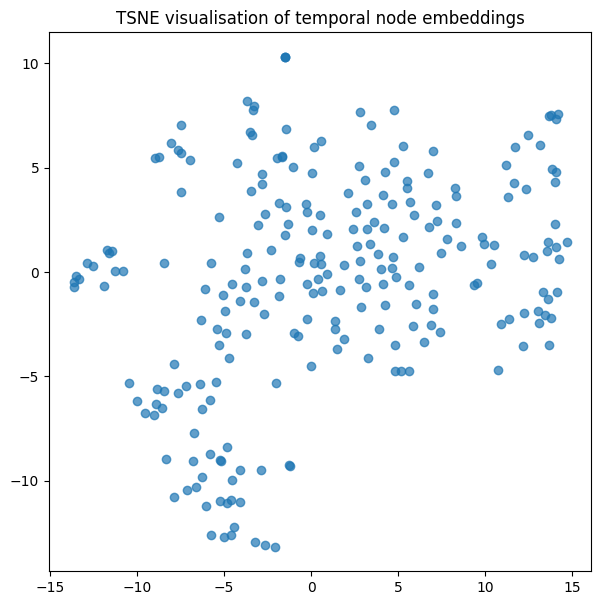

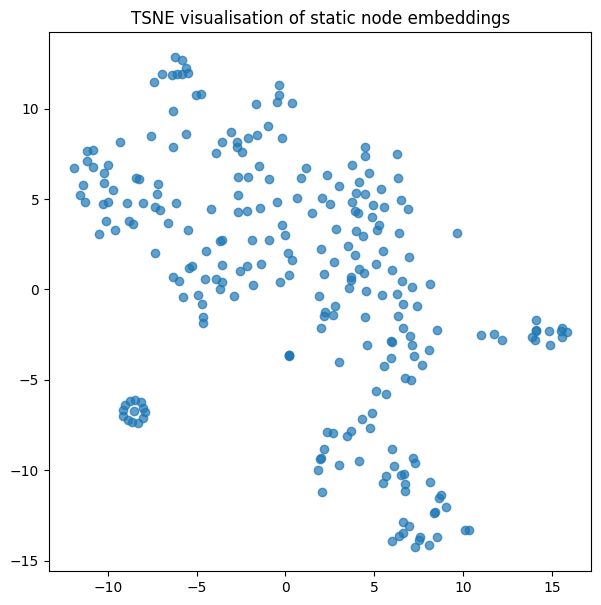

In [62]:
temporal_node_embeddings = temporal_model.wv.vectors
static_node_embeddings = static_model.wv.vectors
plot_tsne("TSNE visualisation of temporal node embeddings", temporal_node_embeddings)
plot_tsne("TSNE visualisation of static node embeddings", static_node_embeddings)

In [63]:
binary_operator = operator_l2

In [64]:
link_examples, link_labels = labelled_links(list(pos), neg)
link_examples_test, link_labels_test = labelled_links(list(pos_test), neg_test)

In [65]:
temporal_clf = link_prediction_classifier()
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")

Score (ROC AUC): 0.85


In [66]:
#temporal
evaluate_accuracy(
    temporal_clf, temporal_link_features_test, link_labels_test
)

Accuracy: 0.7645116440736879
F1 score: 0.7852614896988906


In [67]:
static_clf = link_prediction_classifier()
static_link_features = link_examples_to_features(link_examples, static_embedding)
static_link_features_test = link_examples_to_features(
    link_examples_test, static_embedding
)
static_clf.fit(static_link_features, link_labels)
static_score = evaluate_roc_auc(static_clf, static_link_features_test, link_labels_test)

print(f"Score (ROC AUC): {static_score:.2f}")

Score (ROC AUC): 0.85


In [68]:
#static
evaluate_accuracy(
    static_clf, temporal_link_features_test, link_labels_test
)

Accuracy: 0.6283165334260224
F1 score: 0.6846244593000393


### Decesion Tree

In [69]:
temporal_clf = link_prediction_classifier_DT()
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")
#temporal
evaluate_accuracy(
    temporal_clf, temporal_link_features_test, link_labels_test
)

static_clf = link_prediction_classifier_DT()
static_link_features = link_examples_to_features(link_examples, static_embedding)
static_link_features_test = link_examples_to_features(
    link_examples_test, static_embedding
)
static_clf.fit(static_link_features, link_labels)
static_score = evaluate_roc_auc(static_clf, static_link_features_test, link_labels_test)

print(f"Score (ROC AUC): {static_score:.2f}")
evaluate_accuracy(
    static_clf, temporal_link_features_test, link_labels_test
)

Score (ROC AUC): 0.83
Accuracy: 0.8208202989224888
F1 score: 0.8341643879684736
Score (ROC AUC): 0.83
Accuracy: 0.5569458927123161
F1 score: 0.5876644382143628


In [65]:
arr1 = np.asarray(temporal_link_features_test)
arr2 = np.asarray(temporal_link_features_test)

In [66]:
type(link_labels_test)

numpy.ndarray

In [67]:
# plot_tsne("temporal link embeddings", arr, link_labels_test)
# plot_tsne("static link embeddings", static_link_features_test, link_labels_test)

### Hourly Data

In [70]:
interactions_data_hourly = final_data[['start_time','start_station','end_station']][final_data['trip_route_category']== 'One Way']
interactions_data_hourly = interactions_data_hourly.reset_index(drop=True)
interactions_data_hourly.head()

start_time  start_station  end_station
0  1/1/2023 0:05           3190         3207
1  1/1/2023 0:06           3182         3102
2  1/1/2023 0:09           3046         3112
3  1/1/2023 0:10           3026         3041
4  1/1/2023 0:13           3046         3295

In [71]:
import datetime
interactions_data_hourly['start_time']= pd.to_datetime(interactions_data_hourly['start_time'])
interactions_data_hourly['start_time'] = [((i - datetime.datetime(2023, 1, 1)).total_seconds()/3600) for i in interactions_data_hourly['start_time']]



In [72]:
interactions_data_hourly = interactions_data_hourly.sort_values(by=['start_time']).reset_index(drop=True)
interactions_data_hourly = interactions_data_hourly[["start_station","end_station","start_time"]]
interactions_data_hourly = interactions_data_hourly.rename(columns={"start_station": "source", "end_station": "target","start_time":"time"})
interactions_data_hourly['time'] = np.ceil(interactions_data_hourly['time']).astype(int)
interactions_data_hourly.head()

source  target  time
0    3190    3207     1
1    3182    3102     1
2    3046    3112     1
3    3026    3041     1
4    3046    3295     1

In [73]:
interactions_data_hourly.shape

(996157, 3)

In [74]:
# subset of edges to split
train_subset = 0.25 #from overall graph. division sequential
test_subset = 0.25 #from newer part of graph (not seen during random walks). division random

# number of edges to be kept in the graph
num_edges_graph = int(len(interactions_data_hourly) * (1 - train_subset))

# keep older edges in graph, and predict more recent edges
edges_graph = interactions_data_hourly[:num_edges_graph]
edges_other = interactions_data_hourly[num_edges_graph:]

# split recent edges further to train and test sets
edges_train, edges_test = train_test_split(edges_other, test_size=test_subset)

print(
    f"Number of edges in graph: {len(edges_graph)}\n"
    f"Number of edges in training set: {len(edges_train)}\n"
    f"Number of edges in test set: {len(edges_test)}"
)

Number of edges in graph: 747117
Number of edges in training set: 186780
Number of edges in test set: 62260


In [75]:
graph = StellarGraph(
    nodes=pd.DataFrame(index=interactions_data_hourly['source'].unique()),
    edges=edges_graph,
    edge_weight_column="time",
)

In [76]:
pos, neg = positive_and_negative_links(graph, edges_train)
pos_test, neg_test = positive_and_negative_links(graph, edges_test)

In [77]:
print(
    f"{graph.info()}\n"
    f"Training examples: {len(pos)} positive links, {len(neg)} negative links\n"
    f"Test examples: {len(pos_test)} positive links, {len(neg_test)} negative links"
)

StellarGraph: Undirected multigraph
 Nodes: 254, Edges: 747117

 Node types:
  default: [254]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [747117]
        Weights: range=[1, 6585], mean=3804.43, std=1788.57
        Features: none
Training examples: 25537 positive links, 25537 negative links
Test examples: 17366 positive links, 17366 negative links


In [78]:
num_walks_per_node = 10
walk_length = 80
context_window_size = 10
num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)

In [79]:
temporal_rw = TemporalRandomWalk(graph)
temporal_walks = temporal_rw.run(
    num_cw=num_cw,
    cw_size=context_window_size,
    max_walk_length=walk_length,
    walk_bias="exponential",
)

print("Number of temporal random walks: {}".format(len(temporal_walks)))

Number of temporal random walks: 2582


In [80]:
static_rw = BiasedRandomWalk(graph)
static_walks = static_rw.run(
    nodes=graph.nodes(), n=num_walks_per_node, length=walk_length
)

print("Number of static random walks: {}".format(len(static_walks)))

Number of static random walks: 2540


In [81]:
embedding_size = 128
temporal_model = Word2Vec(
    temporal_walks,
    vector_size=embedding_size,
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=2,
    #iter=1,
)
static_model = Word2Vec(
    static_walks,
    vector_size=embedding_size,
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=2,
    #iter=1,
)

/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_7980/1764596799.py:44: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_7980/1764596799.py:44: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



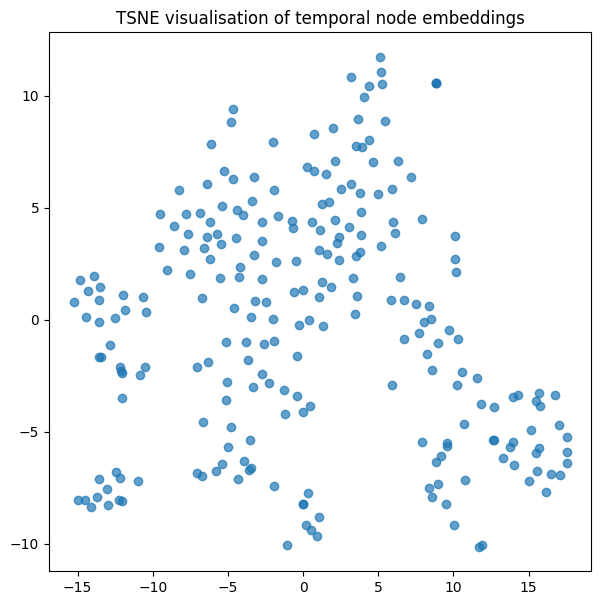

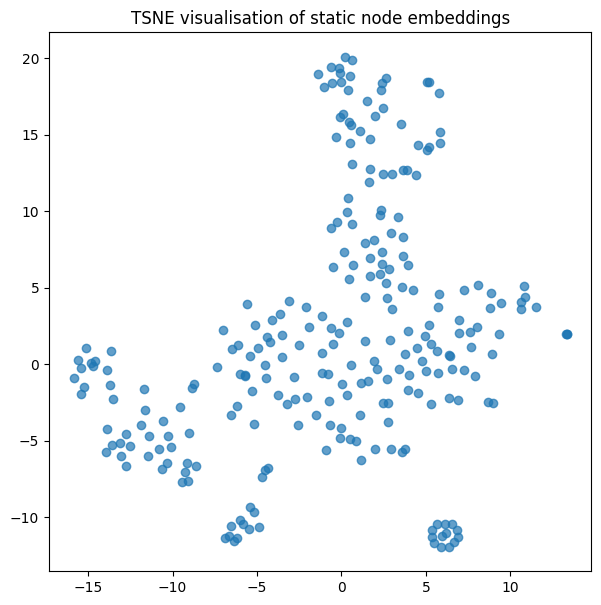

In [82]:
temporal_node_embeddings = temporal_model.wv.vectors
static_node_embeddings = static_model.wv.vectors
plot_tsne("TSNE visualisation of temporal node embeddings", temporal_node_embeddings)
plot_tsne("TSNE visualisation of static node embeddings", static_node_embeddings)

In [83]:
binary_operator = operator_l2

In [84]:
link_examples, link_labels = labelled_links(list(pos), neg)
link_examples_test, link_labels_test = labelled_links(list(pos_test), neg_test)

In [85]:
temporal_clf = link_prediction_classifier()
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")

Score (ROC AUC): 0.85


In [86]:
#temporal
evaluate_accuracy(
    temporal_clf, temporal_link_features_test, link_labels_test
)

Accuracy: 0.7597028676724634
F1 score: 0.779637746211121


In [87]:
static_clf = link_prediction_classifier()
static_link_features = link_examples_to_features(link_examples, static_embedding)
static_link_features_test = link_examples_to_features(
    link_examples_test, static_embedding
)
static_clf.fit(static_link_features, link_labels)
static_score = evaluate_roc_auc(static_clf, static_link_features_test, link_labels_test)

print(f"Score (ROC AUC): {static_score:.2f}")

Score (ROC AUC): 0.86


In [88]:
#static
evaluate_accuracy(
    static_clf, temporal_link_features_test, link_labels_test
)

Accuracy: 0.6251295635149142
F1 score: 0.700730933664322


In [89]:
temporal_clf = link_prediction_classifier_DT()
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")
#temporal
evaluate_accuracy(
    temporal_clf, temporal_link_features_test, link_labels_test
)

static_clf = link_prediction_classifier_DT()
static_link_features = link_examples_to_features(link_examples, static_embedding)
static_link_features_test = link_examples_to_features(
    link_examples_test, static_embedding
)
static_clf.fit(static_link_features, link_labels)
static_score = evaluate_roc_auc(static_clf, static_link_features_test, link_labels_test)

print(f"Score (ROC AUC): {static_score:.2f}")
evaluate_accuracy(
    static_clf, temporal_link_features_test, link_labels_test
)

Score (ROC AUC): 0.84
Accuracy: 0.8247149602671887
F1 score: 0.8375927012751426
Score (ROC AUC): 0.84
Accuracy: 0.5684095358746977
F1 score: 0.615206900092412


### Daily Data

In [90]:
interactions_data_daily = final_data[['start_time','start_station','end_station']][final_data['trip_route_category']== 'One Way']
interactions_data_daily = interactions_data_daily.reset_index(drop=True)
interactions_data_daily.head()

start_time  start_station  end_station
0  1/1/2023 0:05           3190         3207
1  1/1/2023 0:06           3182         3102
2  1/1/2023 0:09           3046         3112
3  1/1/2023 0:10           3026         3041
4  1/1/2023 0:13           3046         3295

In [91]:
import datetime
interactions_data_daily['start_time']= pd.to_datetime(interactions_data_daily['start_time'])
interactions_data_daily['start_time'] = [((i - datetime.datetime(2023, 1, 1)).total_seconds()/86400) for i in interactions_data_daily['start_time']]


In [92]:
interactions_data_daily = interactions_data_daily.sort_values(by=['start_time']).reset_index(drop=True)
interactions_data_daily = interactions_data_daily[["start_station","end_station","start_time"]]
interactions_data_daily = interactions_data_daily.rename(columns={"start_station": "source", "end_station": "target","start_time":"time"})
interactions_data_daily['time'] = np.ceil(interactions_data_daily['time']).astype(int)
interactions_data_daily.head()

source  target  time
0    3190    3207     1
1    3182    3102     1
2    3046    3112     1
3    3026    3041     1
4    3046    3295     1

In [93]:
# subset of edges to split
train_subset = 0.25 #from overall graph. division sequential
test_subset = 0.25 #from newer part of graph (not seen during random walks). division random

# number of edges to be kept in the graph
num_edges_graph = int(len(interactions_data_daily) * (1 - train_subset))

# keep older edges in graph, and predict more recent edges
edges_graph = interactions_data_daily[:num_edges_graph]
edges_other = interactions_data_daily[num_edges_graph:]

# split recent edges further to train and test sets
edges_train, edges_test = train_test_split(edges_other, test_size=test_subset)

print(
    f"Number of edges in graph: {len(edges_graph)}\n"
    f"Number of edges in training set: {len(edges_train)}\n"
    f"Number of edges in test set: {len(edges_test)}"
)

Number of edges in graph: 747117
Number of edges in training set: 186780
Number of edges in test set: 62260


In [94]:
graph = StellarGraph(
    nodes=pd.DataFrame(index=interactions_data_daily['source'].unique()),
    edges=edges_graph,
    edge_weight_column="time",
)

In [95]:
pos, neg = positive_and_negative_links(graph, edges_train)
pos_test, neg_test = positive_and_negative_links(graph, edges_test)

In [96]:
print(
    f"{graph.info()}\n"
    f"Training examples: {len(pos)} positive links, {len(neg)} negative links\n"
    f"Test examples: {len(pos_test)} positive links, {len(neg_test)} negative links"
)

StellarGraph: Undirected multigraph
 Nodes: 254, Edges: 747117

 Node types:
  default: [254]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [747117]
        Weights: range=[1, 275], mean=158.893, std=74.5213
        Features: none
Training examples: 25471 positive links, 25471 negative links
Test examples: 17335 positive links, 17335 negative links


In [97]:
num_walks_per_node = 10
walk_length = 80
context_window_size = 10
num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)

In [98]:
temporal_rw = TemporalRandomWalk(graph)
temporal_walks = temporal_rw.run(
    num_cw=num_cw,
    cw_size=context_window_size,
    max_walk_length=walk_length,
    walk_bias="exponential",
)

print("Number of temporal random walks: {}".format(len(temporal_walks)))

Number of temporal random walks: 3542


In [99]:
static_rw = BiasedRandomWalk(graph)
static_walks = static_rw.run(
    nodes=graph.nodes(), n=num_walks_per_node, length=walk_length
)

print("Number of static random walks: {}".format(len(static_walks)))

Number of static random walks: 2540


In [100]:
embedding_size = 128
temporal_model = Word2Vec(
    temporal_walks,
    vector_size=embedding_size,
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=2,
    #iter=1,
)
static_model = Word2Vec(
    static_walks,
    vector_size=embedding_size,
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=2,
    #iter=1,
)

/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_7980/1764596799.py:44: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_7980/1764596799.py:44: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



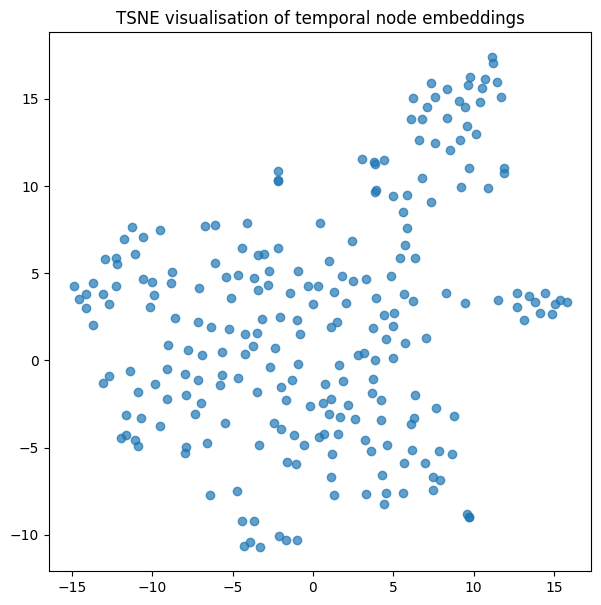

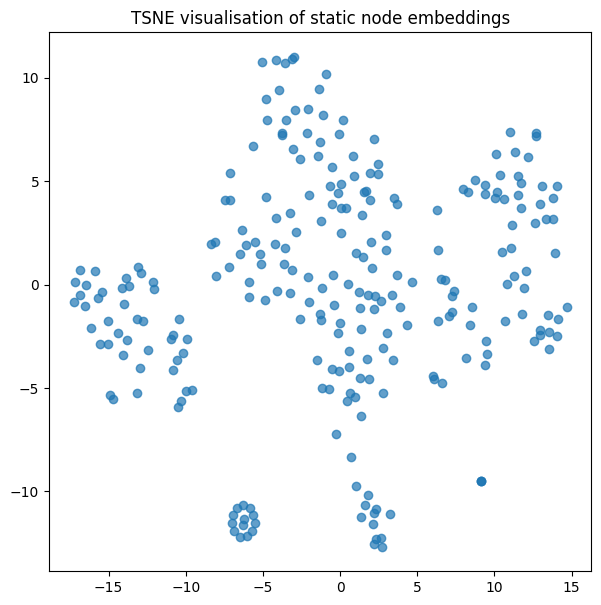

In [101]:
temporal_node_embeddings = temporal_model.wv.vectors
static_node_embeddings = static_model.wv.vectors
plot_tsne("TSNE visualisation of temporal node embeddings", temporal_node_embeddings)
plot_tsne("TSNE visualisation of static node embeddings", static_node_embeddings)

In [102]:
binary_operator = operator_l2

In [103]:
link_examples, link_labels = labelled_links(list(pos), neg)
link_examples_test, link_labels_test = labelled_links(list(pos_test), neg_test)

In [104]:
temporal_clf = link_prediction_classifier()
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")

Score (ROC AUC): 0.86


In [105]:
#temporal
evaluate_accuracy(
    temporal_clf, temporal_link_features_test, link_labels_test
)

Accuracy: 0.7662820882607442
F1 score: 0.7867126424679529


In [106]:
static_clf = link_prediction_classifier()
static_link_features = link_examples_to_features(link_examples, static_embedding)
static_link_features_test = link_examples_to_features(
    link_examples_test, static_embedding
)
static_clf.fit(static_link_features, link_labels)
static_score = evaluate_roc_auc(static_clf, static_link_features_test, link_labels_test)

print(f"Score (ROC AUC): {static_score:.2f}")

Score (ROC AUC): 0.85


In [107]:
#static
evaluate_accuracy(
    static_clf, temporal_link_features_test, link_labels_test
)

Accuracy: 0.5991635419671185
F1 score: 0.6895704425134586


In [108]:
temporal_clf = link_prediction_classifier_DT()
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")
#temporal
evaluate_accuracy(
    temporal_clf, temporal_link_features_test, link_labels_test
)

static_clf = link_prediction_classifier_DT()
static_link_features = link_examples_to_features(link_examples, static_embedding)
static_link_features_test = link_examples_to_features(
    link_examples_test, static_embedding
)
static_clf.fit(static_link_features, link_labels)
static_score = evaluate_roc_auc(static_clf, static_link_features_test, link_labels_test)

print(f"Score (ROC AUC): {static_score:.2f}")
evaluate_accuracy(
    static_clf, temporal_link_features_test, link_labels_test
)

Score (ROC AUC): 0.83
Accuracy: 0.8216902220940294
F1 score: 0.8351114904512963
Score (ROC AUC): 0.83
Accuracy: 0.5694837034900491
F1 score: 0.6181827483884171


### Weekly data

In [44]:
interactions_data_weekly = final_data[['start_time','start_station','end_station']][final_data['trip_route_category']== 'One Way']
interactions_data_weekly = interactions_data_weekly.reset_index(drop=True)
interactions_data_weekly.head()

start_time  start_station  end_station
0  1/1/2023 0:05           3190         3207
1  1/1/2023 0:06           3182         3102
2  1/1/2023 0:09           3046         3112
3  1/1/2023 0:10           3026         3041
4  1/1/2023 0:13           3046         3295

In [45]:
import datetime
interactions_data_weekly['start_time']= pd.to_datetime(interactions_data_weekly['start_time'])
interactions_data_weekly['start_time'] = [((i - datetime.datetime(2023, 1, 1)).total_seconds()/604800) for i in interactions_data_weekly['start_time']]


In [46]:
interactions_data_weekly = interactions_data_weekly.sort_values(by=['start_time']).reset_index(drop=True)
interactions_data_weekly = interactions_data_weekly[["start_station","end_station","start_time"]]
interactions_data_weekly = interactions_data_weekly.rename(columns={"start_station": "source", "end_station": "target","start_time":"time"})
interactions_data_weekly['time'] = np.ceil(interactions_data_weekly['time']).astype(int)
interactions_data_weekly.head()

source  target  time
0    3190    3207     1
1    3182    3102     1
2    3046    3112     1
3    3026    3041     1
4    3046    3295     1

In [47]:
# subset of edges to split
train_subset = 0.25 #from overall graph. division sequential
test_subset = 0.25 #from newer part of graph (not seen during random walks). division random

# number of edges to be kept in the graph
num_edges_graph = int(len(interactions_data_weekly) * (1 - train_subset))

# keep older edges in graph, and predict more recent edges
edges_graph = interactions_data_weekly[:num_edges_graph]
edges_other = interactions_data_weekly[num_edges_graph:]

# split recent edges further to train and test sets
edges_train, edges_test = train_test_split(edges_other, test_size=test_subset)

print(
    f"Number of edges in graph: {len(edges_graph)}\n"
    f"Number of edges in training set: {len(edges_train)}\n"
    f"Number of edges in test set: {len(edges_test)}"
)

Number of edges in graph: 747117
Number of edges in training set: 186780
Number of edges in test set: 62260


In [48]:
graph = StellarGraph(
    nodes=pd.DataFrame(index=interactions_data_weekly['source'].unique()),
    edges=edges_graph,
    edge_weight_column="time",
)

In [49]:
pos, neg = positive_and_negative_links(graph, edges_train)
pos_test, neg_test = positive_and_negative_links(graph, edges_test)

In [50]:
num_walks_per_node = 10
walk_length = 80
context_window_size = 10
num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)

In [51]:
temporal_rw = TemporalRandomWalk(graph)
temporal_walks = temporal_rw.run(
    num_cw=num_cw,
    cw_size=context_window_size,
    max_walk_length=walk_length,
    walk_bias="exponential",
)

print("Number of temporal random walks: {}".format(len(temporal_walks)))

Number of temporal random walks: 21688


In [52]:
static_rw = BiasedRandomWalk(graph)
static_walks = static_rw.run(
    nodes=graph.nodes(), n=num_walks_per_node, length=walk_length
)

print("Number of static random walks: {}".format(len(static_walks)))

Number of static random walks: 2540


In [53]:
embedding_size = 128
temporal_model = Word2Vec(
    temporal_walks,
    vector_size=embedding_size,
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=2,
    #iter=1,
)
static_model = Word2Vec(
    static_walks,
    vector_size=embedding_size,
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=2,
    #iter=1,
)

/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_8240/1764596799.py:44: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_8240/1764596799.py:44: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



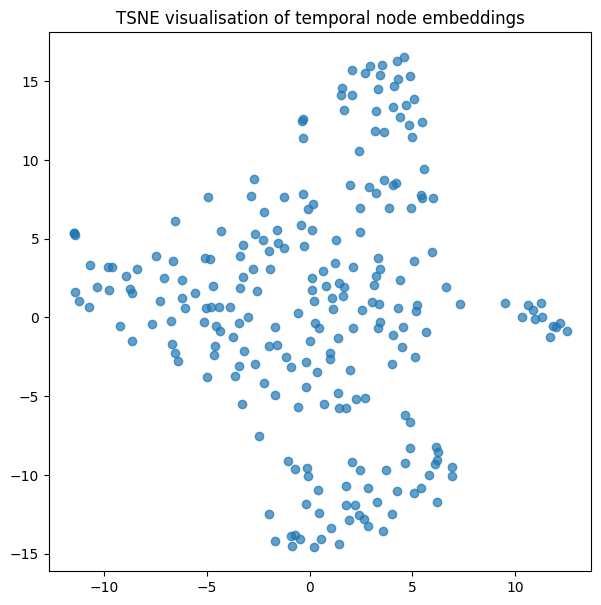

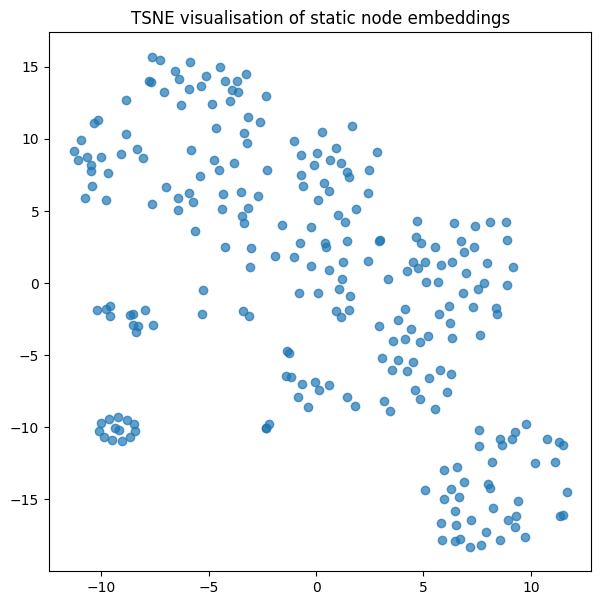

In [54]:
temporal_node_embeddings = temporal_model.wv.vectors
static_node_embeddings = static_model.wv.vectors
plot_tsne("TSNE visualisation of temporal node embeddings", temporal_node_embeddings)
plot_tsne("TSNE visualisation of static node embeddings", static_node_embeddings)

In [55]:
binary_operator = operator_l2

In [56]:
link_examples, link_labels = labelled_links(list(pos), neg)
link_examples_test, link_labels_test = labelled_links(list(pos_test), neg_test)

In [57]:
temporal_clf = link_prediction_classifier_DT()
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")
#temporal
evaluate_accuracy(
    temporal_clf, temporal_link_features_test, link_labels_test
)

static_clf = link_prediction_classifier_DT()
static_link_features = link_examples_to_features(link_examples, static_embedding)
static_link_features_test = link_examples_to_features(
    link_examples_test, static_embedding
)
static_clf.fit(static_link_features, link_labels)
static_score = evaluate_roc_auc(static_clf, static_link_features_test, link_labels_test)

print(f"Score (ROC AUC): {static_score:.2f}")
evaluate_accuracy(
    static_clf, temporal_link_features_test, link_labels_test
)

Score (ROC AUC): 0.83
Accuracy: 0.8226656626506024
F1 score: 0.8361739130434783
Score (ROC AUC): 0.83
Accuracy: 0.5499304911955515
F1 score: 0.5726542734572654
